# UKdrivers

注意：こちらは応用編です。最初に [8school.ipynb](8school.ipynb)をご覧ください。

StunでUKdriversデータを扱うのに関しては、こちらの[Rstanでの記事](https://github.com/sinhrks/stan-statespace)を参考にしました。

## データの入手方法

状態空間モデルの例として、
["An Introduction to State Space Time Series Analysis" サポートページ](http://www.ssfpack.com/CKbook.html)から、
ファイル [http://staff.feweb.vu.nl/koopman/projects/ckbook/OxCodeAll.zip](http://staff.feweb.vu.nl/koopman/projects/ckbook/OxCodeAll.zip) をダウンロードして解凍します。
解凍して得られるフォルダの `Chapter_7` ディレクトリ下にある `UKdriversKSI.txt`, `logUKpetroprice.txt`を、このjupyter notebookのあるディレクトリにコピーします。

なお、この教科書は「状態空間時系列分析入門」という邦題で翻訳書が発売されています。状態空間モデルを用いた時系列分析に関するお勧めの教科書です。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import statsmodels.api as sm
import pystan

## データの説明

`UKdriversKSI.txt` は "monthly UK drivers KSI 1969-1984" つまり 1969-1984 年の月次の英国ドライバーの死傷者数のデータ$\{y_t\}$です。今回の目的はこれを解析することです。

`logUKpetroprice.txt` は "monthly UK log(petrol price) 1969-1984" であり、同じ期間の石油価格の対数です。死傷者数の説明変数に石油価格$\{x_t\}$を追加します。

また、英国では 1983/2 からシートベルト法が施行されたため、1983/2 ($t=169$) 以後は法律の影響があるはずです。これも後ほど、説明変数に$\{w_t\}$として取り込みます。 

In [2]:
df_driver = pd.read_table('UKdriversKSI.txt', skiprows=1, header=None, names=['v'])
df_petrol = pd.read_table('logUKpetrolprice.txt', skiprows=1, header=None, names=['v'])
print(df_driver.shape)
#df_driver.head()

(192, 1)


シートベルト法制化前を$0$、法制化後を$1$として、法制化の効果を考えることにします。

In [3]:
seats=np.concatenate((np.zeros((1982-1968)*12+1), np.ones((1984 - 1982)*12-1)))

死傷者数は対数変換したほうが適切と考えるので対数変換します。

簡単にグラフを書いてみます。

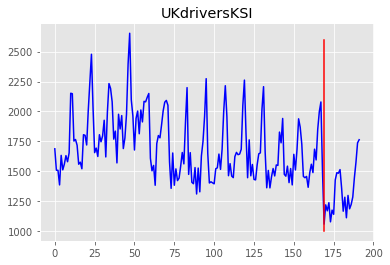

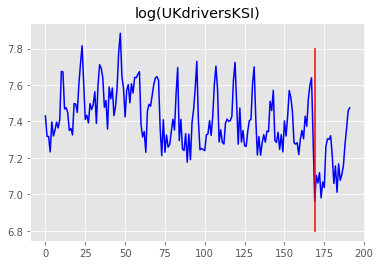

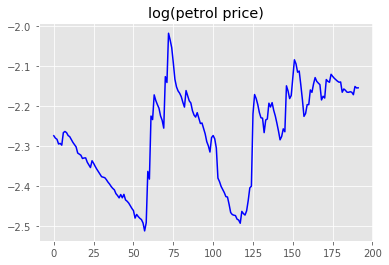

In [4]:
xps = np.linspace(0,191,192) # x座標
rawdrivers = [float(v) for v in df_driver['v'].values] # 生の死傷者数
drivers = [np.log(v) for v in rawdrivers] # 対数変換した死傷者数
petrols = [float(v) for v in df_petrol['v'].values] # 対数変換した死傷者数

plt.plot(xps, rawdrivers, "b")
plt.plot([169,169], [1000, 2600], "r")
plt.title('UKdriversKSI')
plt.show()
plt.plot(xps, drivers, "b")
plt.plot([169,169], [6.8, 7.8], "r")
plt.title('log(UKdriversKSI)')
plt.show()
plt.plot(xps, petrols, "b")
plt.title('log(petrol price)')
plt.show()

drivers は(シートベルト法の影響と12ヶ月周期を除けば)値がほぼ一定であるように見えます。

12ヶ月周期があることを確認するため、自己相関係数をみます。

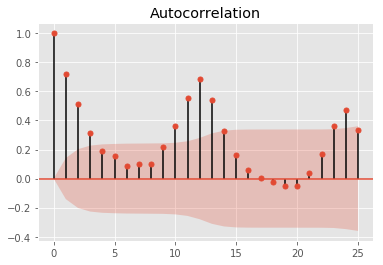

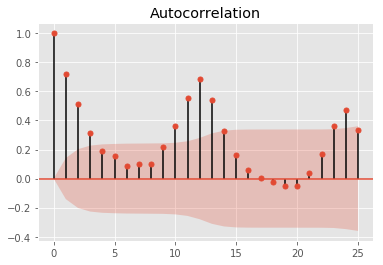

In [5]:
sm.graphics.tsa.plot_acf(drivers, lags=25)

## 単なる線形モデル

データが
$$y_t \sim \mathcal{N}(\mu + \beta x_t + \lambda w_t + s_t, \; \sigma_{\mathrm{obs}})$$
$$\sum_{i=1}^{12}s_i = 0, \;\; \text{周期12の季節項}$$
と表現されると仮定します。

モデルを表現します
* data
   * $n$ : データ数
   * $\{y_t\}$ : log(運転者死亡数)
   * $\{x_t\}$ : log(石油価格)
   * $\{w_t\}$ : シートベルト法制化のダミー変数(0/1=法制化)
* parameters
   * $\mu$ : log(運転者死亡数)の平均
   * $\mathrm{seas}_i \; (i=1 \sim 11)$ : 周期=12、制約 $\sum_{i=1}^{12} \mathrm{seas}_i = 0$
   * $\beta$ : log(石油価格)の係数
   * $\lambda$ : シートベルト法制化の効果
   * $\sigma_{\mathrm{obs}}$ : 観測誤差
* transformed parameters
   * $s_t$ : $\mathrm{seas}_i$ を繰り返したもの
   * $\hat{y}_t = \mu + \beta x_t + \lambda w_t$
* model
   * $ y_t \sim \mathcal{N}(\hat{y}_t + s_t, \sigma_{\mathrm{obs}}) $

In [6]:
model_code = """
data {
  int<lower=1> n;
  vector[n] y; # driver
  vector[n] x; # petrol
  vector[n] w; # seatbelt
}
parameters {
  real mu; # level
  vector[11] seas; # seasonal term
  real beta; # reg. param
  real lambda; # coeff.
  real<lower=0> sigma_obs; # obs. error
}
transformed parameters {
  vector[n] s;
  vector[n] yhat;
  for(t in 1:11) {
    s[t] = seas[t];
  }
  for(t in 12:n) {
    s[t] = - s[t-11] - s[t-10] - s[t-9] - s[t-8] - s[t-7] - s[t-6] - s[t-5] - s[t-4] - s[t-3] - s[t-2] - s[t-1];
  }
  for(t in 1:n) {
    yhat[t] = mu + beta * x[t] + lambda * w[t];
  }
}
model {
  for(t in 1:n)
    y[t] ~ normal(yhat[t] + s[t], sigma_obs);
}
"""

In [7]:
data = {'n': 192, 'y': drivers, 'x': petrols, 'w': seats }

In [8]:
%time fit = pystan.stan(model_code=model_code, data=data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1bafc8fd80a33a069c1e0de861653e8b NOW.


CPU times: user 1.08 s, sys: 111 ms, total: 1.19 s
Wall time: 30.3 s


In [9]:
print(fit)

Inference for Stan model: anon_model_1bafc8fd80a33a069c1e0de861653e8b.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu           6.4  3.8e-3   0.13   6.16   6.31    6.4   6.49   6.66   1178    1.0
seas[0]   7.2e-3  4.6e-4   0.02  -0.03-6.7e-3 7.0e-3   0.02   0.05   2000    1.0
seas[1]    -0.11  4.6e-4   0.02  -0.15  -0.12  -0.11  -0.09  -0.07   2000    1.0
seas[2]    -0.07  4.5e-4   0.02  -0.11  -0.08  -0.07  -0.05  -0.03   2000    1.0
seas[3]    -0.14  4.7e-4   0.02  -0.18  -0.16  -0.14  -0.13   -0.1   2000    1.0
seas[4]    -0.05  4.6e-4   0.02  -0.09  -0.07  -0.05  -0.04  -0.01   2000    1.0
seas[5]    -0.09  4.7e-4   0.02  -0.13   -0.1  -0.09  -0.07  -0.05   2000    1.0
seas[6]    -0.04  4.8e-4   0.02  -0.08  -0.05  -0.04  -0.02 5.3e-3   2000    1.0
seas[7]    -0.03  4.9e-4   0.02  -0.07  -0.05  -0.03  -0.01   0.01   2000    1.0
sea

In [10]:
la = fit.extract(permuted=True)

In [11]:
def ave_s(la, vname):
    return np.average(la[vname])
def ave_v(la, vname):
    n = len(la[vname])
    acc = np.zeros(192)
    for i in range(0, n):
        acc = acc + la[vname][i]
    return (acc/n)

mu=6.401519902584229, beta=-0.4521406008228121, lambda=-0.19719761334353922
sigma_obs=0.08671881552724456


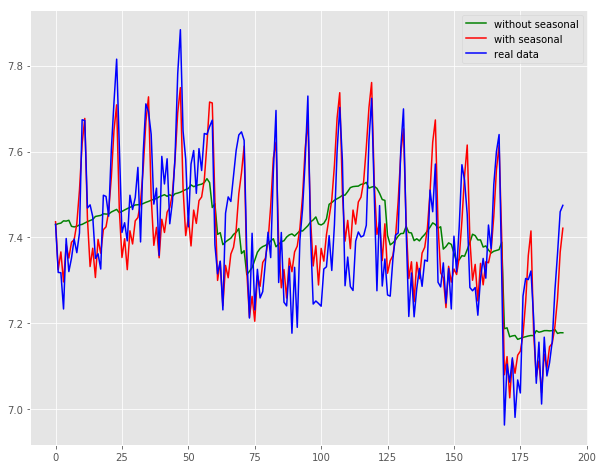

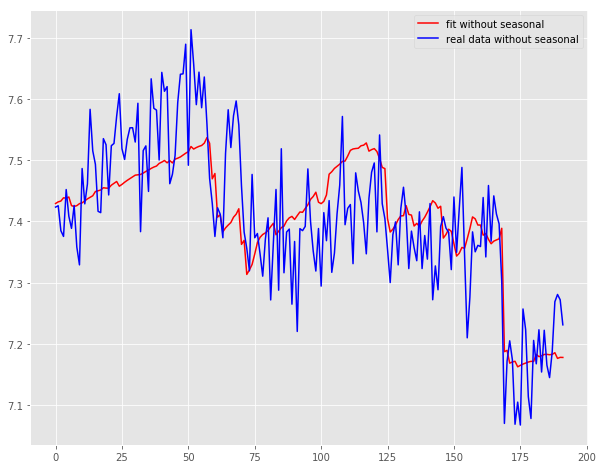

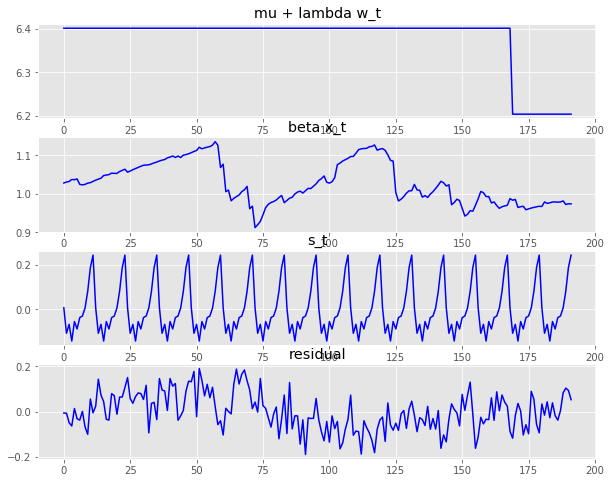

In [12]:
term_mu = np.ones(192)*ave_s(la, 'mu') # 平均値 mu
term_beta = np.array(petrols)*ave_s(la, 'beta') # 石油の影響
term_lambda = seats*ave_s(la, 'lambda') # 法改正の影響 
term_seasonal = ave_v(la, 's')
print("mu={0}, beta={1}, lambda={2}".format(ave_s(la, 'mu'), ave_s(la, 'beta'), ave_s(la, 'lambda')))
print("sigma_obs={0}".format(ave_s(la, 'sigma_obs')))

plt.figure(figsize=(10, 8))
plt.plot(xps, term_mu+term_lambda+term_beta, "g", label='without seasonal')
plt.plot(xps, term_mu+term_lambda+term_beta+term_seasonal, "r", label='with seasonal')
plt.plot(xps, drivers, "b", label='real data')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(xps, term_mu+term_lambda+term_beta, "r", label='fit without seasonal')
plt.plot(xps, drivers-term_seasonal, "b", label='real data without seasonal')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.subplot(4,1,1)
plt.plot(xps, term_mu+term_lambda, "b", label='$\mu + \lambda w_t$')
plt.title('mu + lambda w_t')
plt.subplot(4,1,2)
plt.plot(xps, term_beta, "b", label='$\beta x_t$')
plt.title('beta x_t')
plt.subplot(4,1,3)
plt.plot(xps, term_seasonal, "b", label='seasonal')
plt.title('s_t')
plt.subplot(4,1,4)
plt.plot(xps, drivers-(term_mu+term_lambda+term_beta+term_seasonal), "b", label='residual')
plt.title('residual')
plt.show()

季節成分だけを引いたものの自己相関係数をプロットすると、自己相関がかなり残っています。残差にはなめらかな変化が残っているように見えます。平均値が一定であるという仮定に無理がありそうです。

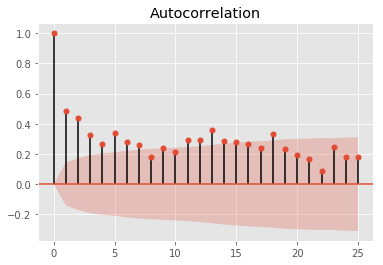

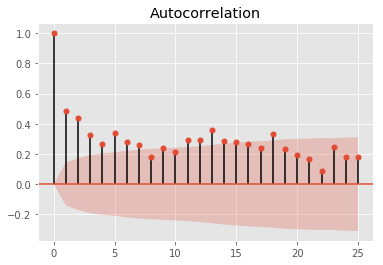

In [13]:
sm.graphics.tsa.plot_acf(drivers-(term_mu+term_lambda+term_beta+term_seasonal), lags=25)

## 状態空間モデル

ローカルレベルモデル、さらに季節項にも変動を許します。
$$y_t \sim \mathcal{N}(\mu_t + \beta x_t + \lambda w_t + s_t, \; \sigma_{\mathrm{obs}})$$
$$\mu_t \sim \mathcal{N}(\mu_{t-1}, \; \sigma_\mu)$$
$$s_t \sim \mathcal{N}(-\sum_{i=1}^{11}s_{t-i}, \; \sigma_s)$$


In [14]:
model_code = """
data {
  int<lower=1> n;
  vector[n] y; # driver
  vector[n] x; # petrol
  vector[n] w; # seatbelt
}
parameters {
  vector<lower=mean(y)-3*sd(y), upper=mean(y)+3*sd(y)>[n] mu;
  vector[n] s; # seasonal term
  real beta; # reg. param
  real lambda; # coeff.
  real<lower=0> sigma_mu; # mu error
  real<lower=0> sigma_s; # seas error
  real<lower=0> sigma_obs; # obs. error
}
transformed parameters {
  vector[n] yhat;
  for(t in 1:n) {
    yhat[t] = mu[t] + beta * x[t] + lambda * w[t];
  }
}
model {
  for(t in 12:n) {
    s[t] ~ normal(-s[t-11]-s[t-10]-s[t-9]-s[t-8]-s[t-7]-s[t-6]-s[t-5]-s[t-4]-s[t-3]-s[t-2]-s[t-1], sigma_s);
  }
  for(t in 2:n)
    mu[t] ~ normal(mu[t-1], sigma_mu);
  for(t in 1:n)
    y[t] ~ normal(yhat[t] + s[t], sigma_obs);

  sigma_mu ~ inv_gamma(0.001, 0.001);
  sigma_s ~ inv_gamma(0.001, 0.001);
  sigma_obs ~ inv_gamma(0.001, 0.001);}
"""

In [15]:
%time fit = pystan.stan(model_code=model_code, data=data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_14ede90e8619d2826e7ae5a760caa618 NOW.


CPU times: user 1.24 s, sys: 124 ms, total: 1.37 s
Wall time: 2min 1s


In [16]:
la = fit.extract(permuted=True)
print(fit)

Inference for Stan model: anon_model_14ede90e8619d2826e7ae5a760caa618.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       7.14    0.06   0.14   6.95   7.02   7.11   7.22   7.47      6   1.43
mu[1]       7.14    0.06   0.14   6.96   7.02   7.11   7.22   7.47      6   1.43
mu[2]       7.13    0.06   0.14   6.96   7.02    7.1   7.21   7.47      6   1.43
mu[3]       7.13    0.06   0.14   6.96   7.02    7.1   7.22   7.46      6   1.44
mu[4]       7.14    0.06   0.14   6.97   7.02   7.11   7.22   7.47      6   1.43
mu[5]       7.14    0.06   0.14   6.96   7.02   7.11   7.22   7.47      6   1.44
mu[6]       7.14    0.06   0.14   6.96   7.02   7.11   7.22   7.46      6   1.45
mu[7]       7.14    0.06   0.14   6.96   7.03   7.11   7.22   7.46      6   1.44
mu[8]       7.14    0.06   0.14   6.97   7.03   7.11   7.22   7.46      6   1.44
mu[

beta=-0.12105209757885532, lambda=-0.2396863547347663
sigma_mu=0.019976458468698062, sigma_s=0.0037743268873781798, sigma_obs=0.06166733831844094


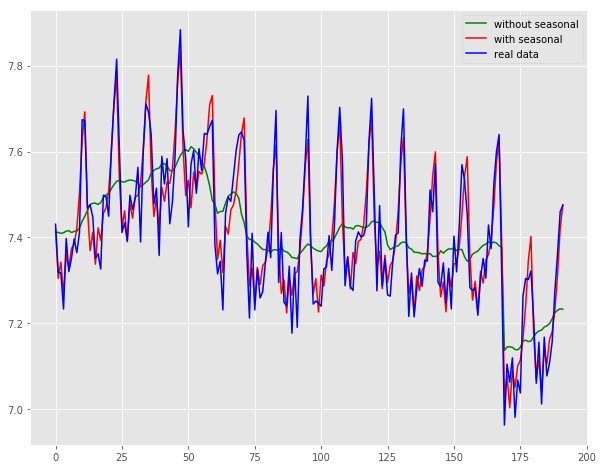

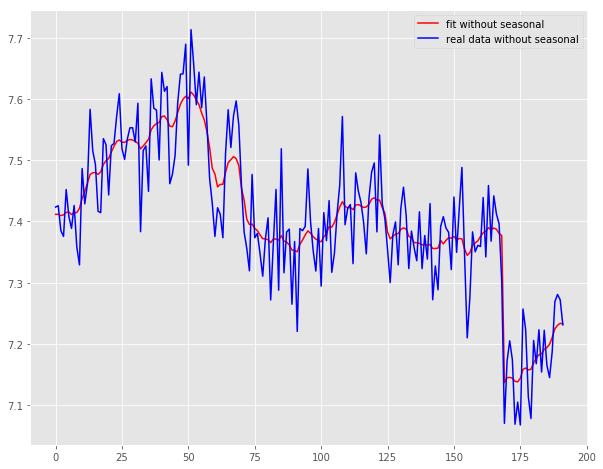

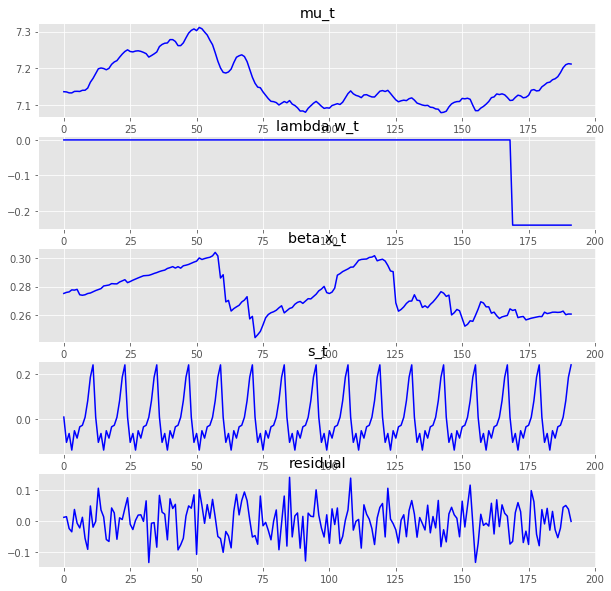

In [17]:
term_mu = ave_v(la,'mu') # 平均値 mu
term_beta = np.array(petrols)*ave_s(la,'beta') # 石油の影響
term_lambda = seats*ave_s(la,'lambda') # 法改正の影響 
term_s = ave_v(la,'s')
term_res = drivers-(term_mu+term_lambda+term_beta+term_seasonal)
print("beta={0}, lambda={1}".format(ave_s(la, 'beta'), ave_s(la, 'lambda')))
print("sigma_mu={0}, sigma_s={1}, sigma_obs={2}".format( \
    ave_s(la, 'sigma_mu'), ave_s(la, 'sigma_s'), ave_s(la, 'sigma_obs')))

plt.figure(figsize=(10, 8))
plt.plot(xps, term_mu+term_lambda+term_beta, "g", label='without seasonal')
plt.plot(xps, term_mu+term_lambda+term_beta+term_seasonal, "r", label='with seasonal')
plt.plot(xps, drivers, "b", label='real data')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(xps, term_mu+term_lambda+term_beta, "r", label='fit without seasonal')
plt.plot(xps, drivers-term_seasonal, "b", label='real data without seasonal')
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(5,1,1)
plt.plot(xps, term_mu, "b", label='$\mu_t$')
plt.title('mu_t')
plt.subplot(5,1,2)
plt.plot(xps, term_lambda, "b", label='$\lambda w_t$')
plt.title('lambda w_t')
plt.subplot(5,1,3)
plt.plot(xps, term_beta, "b", label='$\beta x_t$')
plt.title('beta x_t')
plt.subplot(5,1,4)
plt.plot(xps, term_seasonal, "b", label='seasonal')
plt.title('s_t')
plt.subplot(5,1,5)
plt.plot(xps, term_res, "b", label='residue')
plt.title('residual')
plt.show()

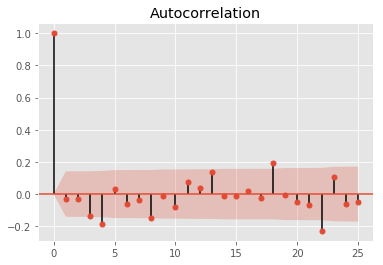

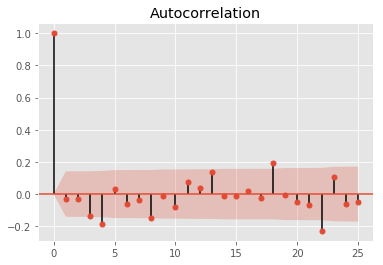

In [18]:
sm.graphics.tsa.plot_acf(term_res, lags=25)

## トレンドモデル

$$\mu_t - \mu_{t-1} = \mu_{t-1} - \mu_{t-2} + \epsilon_t$$
より
$$\mu_t \sim \mathcal{N}(2\mu_{t-1} - \mu_{t-2}, \sigma_\mu)$$


In [19]:
model_code = """
data {
  int<lower=1> n;
  vector[n] y; # driver
  vector[n] x; # petrol
  vector[n] w; # seatbelt
}
parameters {
  vector<lower=mean(y)-3*sd(y), upper=mean(y)+3*sd(y)>[n] mu;
  vector[n] s; # seasonal term
  real beta; # reg. param
  real lambda; # coeff.
  real<lower=0> sigma_mu; # mu error
  real<lower=0> sigma_s; # seas error
  real<lower=0> sigma_obs; # obs. error
}
transformed parameters {
  vector[n] yhat;
  for(t in 1:n) {
    yhat[t] = mu[t] + beta * x[t] + lambda * w[t];
  }
}
model {
  for(t in 12:n) {
    s[t] ~ normal(-s[t-11]-s[t-10]-s[t-9]-s[t-8]-s[t-7]-s[t-6]-s[t-5]-s[t-4]-s[t-3]-s[t-2]-s[t-1], sigma_s);
  }
  for(t in 3:n)
    mu[t] ~ normal(2*mu[t-1]-mu[t-2], sigma_mu);
  for(t in 1:n)
    y[t] ~ normal(yhat[t] + s[t], sigma_obs);

  sigma_mu ~ inv_gamma(0.001, 0.001);
  sigma_s ~ inv_gamma(0.001, 0.001);
  sigma_obs ~ inv_gamma(0.001, 0.001);}
"""

In [20]:
%time fit = pystan.stan(model_code=model_code, data=data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0b0fa5a39dd51231876f57489da4caeb NOW.


CPU times: user 1.26 s, sys: 126 ms, total: 1.39 s
Wall time: 2min 6s


In [21]:
la = fit.extract(permuted=True)
print(fit)

Inference for Stan model: anon_model_0b0fa5a39dd51231876f57489da4caeb.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       7.09    0.05   0.08   6.96   7.03   7.08   7.14   7.27      3   2.42
mu[1]        7.1    0.06   0.08   6.96   7.03   7.08   7.15   7.27      2   2.54
mu[2]        7.1    0.06   0.08   6.97   7.04   7.09   7.15   7.28      2   2.65
mu[3]       7.11    0.06   0.08   6.98   7.05   7.09   7.16   7.28      2   2.76
mu[4]       7.11    0.06   0.08   6.99   7.05    7.1   7.16   7.28      2   2.85
mu[5]       7.12    0.06   0.08   6.99   7.06    7.1   7.17   7.29      2   2.92
mu[6]       7.12    0.06   0.08    7.0   7.06   7.11   7.17    7.3      2   2.99
mu[7]       7.13    0.06   0.08   7.01   7.07   7.12   7.18    7.3      2   3.04
mu[8]       7.13    0.06   0.08   7.01   7.07   7.12   7.18   7.31      2   3.07
mu[

beta=-0.13164905280830164, lambda=-0.2722196936544204
sigma_mu=0.001149060386888443, sigma_s=0.0038235105421477052, sigma_obs=0.06736764807820415


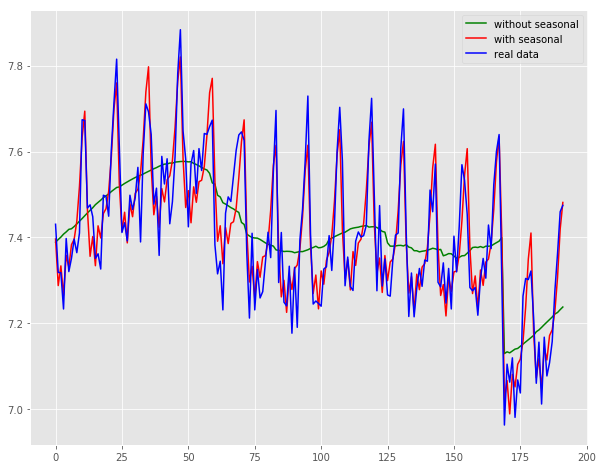

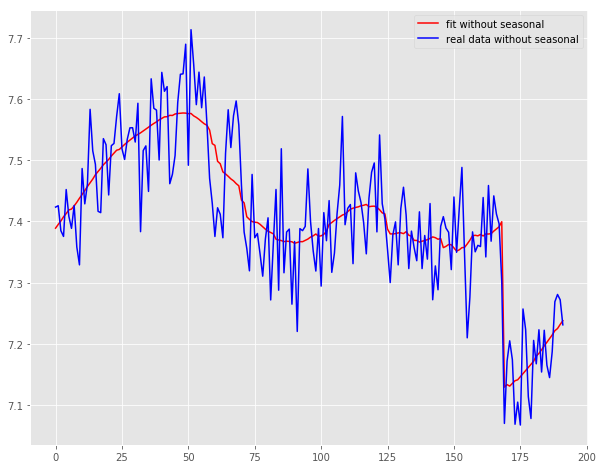

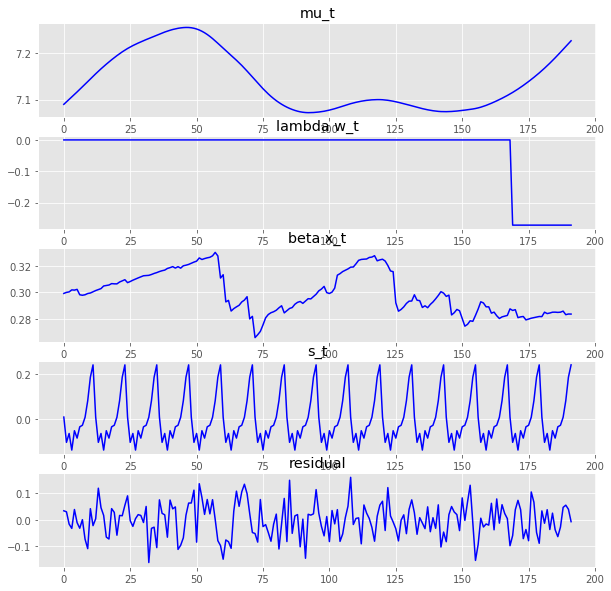

In [22]:
term_mu = ave_v(la,'mu') # 平均値 mu
term_beta = np.array(petrols)*ave_s(la,'beta') # 石油の影響
term_lambda = seats*ave_s(la,'lambda') # 法改正の影響 
term_s = ave_v(la,'s')
term_res = drivers-(term_mu+term_lambda+term_beta+term_seasonal)
print("beta={0}, lambda={1}".format(ave_s(la, 'beta'), ave_s(la, 'lambda')))
print("sigma_mu={0}, sigma_s={1}, sigma_obs={2}".format( \
    ave_s(la, 'sigma_mu'), ave_s(la, 'sigma_s'), ave_s(la, 'sigma_obs')))

plt.figure(figsize=(10, 8))
plt.plot(xps, term_mu+term_lambda+term_beta, "g", label='without seasonal')
plt.plot(xps, term_mu+term_lambda+term_beta+term_seasonal, "r", label='with seasonal')
plt.plot(xps, drivers, "b", label='real data')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(xps, term_mu+term_lambda+term_beta, "r", label='fit without seasonal')
plt.plot(xps, drivers-term_seasonal, "b", label='real data without seasonal')
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(5,1,1)
plt.plot(xps, term_mu, "b", label='$\mu_t$')
plt.title('mu_t')
plt.subplot(5,1,2)
plt.plot(xps, term_lambda, "b", label='$\lambda w_t$')
plt.title('lambda w_t')
plt.subplot(5,1,3)
plt.plot(xps, term_beta, "b", label='$\beta x_t$')
plt.title('beta x_t')
plt.subplot(5,1,4)
plt.plot(xps, term_seasonal, "b", label='seasonal')
plt.title('s_t')
plt.subplot(5,1,5)
plt.plot(xps, term_res, "b", label='residue')
plt.title('residual')
plt.show()

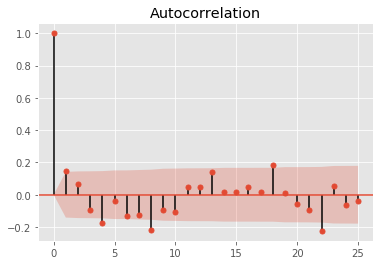

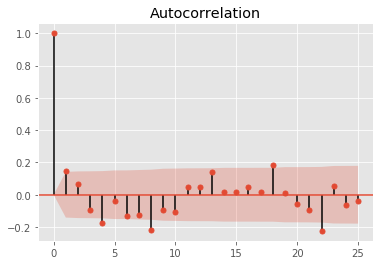

In [23]:
sm.graphics.tsa.plot_acf(term_res, lags=25)